In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax

import icomo

## Model

In [23]:
# Function to calculate the modulating factor 'm' based on provided arguments
def m(args):
    # Calculate the modulating factor 'm' which depends on 'm_max', 'H_thres', 'm_eps', and 'H'
    return args["m_max"] - args["m_max"] / args["H_thres"] * args[
        "m_eps"
    ] * jax.numpy.log(1 + jax.numpy.exp((args["H_thres"] - args["H"]) / args["m_eps"]))


# Function to calculate the testing rate of STI
def lambda_STI(args):
    return (
        args["lambda_0_a"]  # Baseline test rate
        + args["c"]
        * (1 - m(args))
        * args["beta_HIV"]
        * args["H"]
        * (1 - args["P_HIV"])  # HIV dependent term
        + args["lambda_P"]
        * args["P_HIV"]  # Proportional infection rate due to HIV prevalence
    )


# Function to calculate infection from asymptomatic STI individuals
def infect_ia(y, args):
    return (
        (args["asymptomatic"])
        * (1 - m(args) * (1 - args["P_HIV"]))
        * args["beta_STI"]
        * (y["Ia_STI"] + y["Is_STI"])
    )


# Function to calculate infection from symptomatic STI individuals
def infect_is(y, args):
    return (
        (1 - args["asymptomatic"])
        * (1 - m(args) * (1 - args["P_HIV"]))
        * args["beta_STI"]
        * (y["Is_STI"] + y["Ia_STI"])
    )


# Main model function that defines the differential equations of the system
def model(t, y, args):
    cm = icomo.CompModel(y)  # Initialize the compartmental model

    # Basic STI dynamics
    cm.flow("S_STI", "Ia_STI", infect_ia(y, args))  # Susceptible to asymptomatic
    cm.flow("S_STI", "Is_STI", infect_is(y, args))  # Susceptible to symptomatic
    cm.flow(
        "Ia_STI", "S_STI", args["gamma_STI"]
    )  # Asymptomatic to susceptible (recovery)
    cm.flow("Ia_STI", "T_STI", lambda_STI(args))  # Asymptomatic to tested and treatment
    cm.flow("Is_STI", "T_STI", args["lambda_0"])  # Symptomatic to tested and treatment
    cm.flow(
        "T_STI", "S_STI", args["gammaT_STI"]
    )  # Treatment to susceptible (immunity loss)

    # Vital dynamics (natural death or other forms of removal)
    cm.flow("Ia_STI", "S_STI", args["mu"])  # Death/removal from asymptomatic
    cm.flow("Is_STI", "S_STI", args["mu"])  # Death/removal from symptomatic
    cm.flow("T_STI", "S_STI", args["mu"])  # Death/removal from treatment

    # Return the differential changes
    return cm.dy


# Arguments for the model
args = {
    "beta_HIV": 0.6341 / 360.0,  # HIV infection rate per day
    "beta_STI": 0.0016 * 5.0,  # STI infection rate
    "mu": 1.0 / 45.0 / 360.0,  # Natural death rate per day
    "gamma_STI": 1.0 / 1.32 / 360.0,  # Recovery rate from asymptomatic STI per day
    "gammaT_STI": 1.0 / 14.0,  # Recovery rate from treated STI per day
    "lambda_0_a": 0.0,  # Baseline test rate for asymptomatic STI
    "lambda_0": 0.3 / 11.0,  # Baseline test rate for symptomatic STI
    "lambda_P": 1 / 3 / 360,  # Infection rate due to HIV prevalence
    "asymptomatic": 0.9,  # Proportion of asymptomatic infections
    "m_max": 0.8,  # Maximum modulating factor
    "H_thres": 0.1,  # HIV threshold
    "m_eps": 0.01,  # Small constant for smoothing
    "Phi_r": 40.0,  # Not used in the current model
    "H_tau": 20.0,  # Not used in the current model
    "c": 50.0,  # Scaling factor for HIV interaction term
    "H": 0.0,  # Initial HIV prevalence
    "P_HIV": 0.0,  # Initial proportion of HIV positive individuals
}

# Initial state of the compartments
y0 = {
    "S_STI": 0.99,  # Initial susceptible proportion
    "Ia_STI": 0.009,  # Initial asymptomatic proportion
    "Is_STI": 0.001,  # Initial symptomatic proportion
    "T_STI": 0.0,  # Initial treated proportion
}

In [24]:
# Define the time span for the simulation
ts = np.linspace(0, 3600 * 5, 3600)

# Create an ODE integrator object using the icomo library
integrator_object = icomo.ODEIntegrator(
    ts_out=ts,  # Output time points
    t_0=min(ts),  # Initial time point
    ts_solver=ts,  # Time points for the solver to use
)

# Get the integration function for the model
integrator = integrator_object.get_func(
    model
)  # Returns a function that can be used to solve the ODEs defined in the 'model' function

## Sweep

## Ps, Lambda_P are continuous from 1 to 1 and 1 to 6 respectively. Hs with 8 discrete values

In [5]:
# Define the ranges for lambda_P (proportional infection rate due to HIV prevalence) and P (proportion of HIV positive individuals)
lambda_P_values = np.linspace(1 / 360, 6 / 360, 101)  # 101 points from 1/360 to 6/360
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0

# Define the discrete values for H (HIV prevalence)
# Hs = np.linspace(0, 0.2, 8)  # 8 discrete values from 0 to 0.2
Hs = np.logspace(-3, -0.698, 8)

In [ ]:
# Dictionary to store results for different H values
results = {}

# Loop over each value of H
for H in Hs:
    res_size = [
        len(lambda_P_values),
        len(Ps),
    ]  # Determine the size of the result matrices
    res_Ia = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic STI infections
    res_Is = np.zeros(
        res_size
    )  # Initialize result matrix for symptomatic STI infections
    res_T = np.zeros(res_size)  # Initialize result matrix for treated STI infections
    res_infections = np.zeros(res_size)  # Initialize result matrix for total infections
    res_asymp_infections = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic infections
    res_symp_infections = np.zeros(
        res_size
    )  # Initialize result matrix for symptomatic infections
    res_tests = np.zeros(res_size)  # Initialize result matrix for the number of tests
    res_asymp_tests = np.zeros(
        res_size
    )  # Initialize result matrix for the number of tests for asymptomatic
    res_symp_tests = np.zeros(
        res_size
    )  # Initialize result matrix for the number of tests for symptomatic
    check = np.zeros(res_size)  # Initialize matrix to check for convergence

    # Loop over each lambda_P value
    for i, lambda_P in enumerate(lambda_P_values):
        for j, P in enumerate(Ps):
            args_mod = args.copy()
            args_mod["H"] = H
            args_mod["P_HIV"] = P
            args_mod["lambda_P"] = lambda_P

            # Integrate the model with the modified arguments
            output = integrator(y0=y0, constant_args=args_mod)

            # Get the final state of the system
            y1 = {key: value[-1] for key, value in output.items()}

            # Record the final asymptomatic STI infections
            res_Ia[i, j] = output["Ia_STI"][-1]

            # Record the final symptomatic STI infections
            res_Is[i, j] = output["Is_STI"][-1]

            # Record the final treated STI infections
            res_T[i, j] = output["T_STI"][-1]

            # Calculate total new infections
            res_infections[i, j] = (
                infect_is(y1, args_mod) + infect_ia(y1, args_mod)
            ) * y1["S_STI"]

            # Calculate new asymptomatic infections
            res_asymp_infections[i, j] = infect_ia(y1, args_mod) * y1["S_STI"]

            # Calculate new symptomatic infections
            res_symp_infections[i, j] = infect_is(y1, args_mod) * y1["S_STI"]

            # Detected (by testing) new infections from symptomatic and asymptomatic
            res_tests[i, j] = (lambda_STI(args_mod) * y1["Ia_STI"]) + (
                args["lambda_0"] * y1["Is_STI"]
            )

            # Detected (by testing) new infections from asymptomatic
            res_asymp_tests[i, j] = lambda_STI(args_mod) * y1["Ia_STI"]

            # Detected (by testing) new infections from symptomatic
            res_symp_tests[i, j] = args["lambda_0"] * y1["Is_STI"]

            # Check for convergence by comparing the last and the second last values
            check[i, j] = (
                abs(output["Ia_STI"][-1] - output["Ia_STI"][-101])
                + abs(output["T_STI"][-1] - output["T_STI"][-101])
                + abs(output["Is_STI"][-1] - output["Is_STI"][-101])
            )

    # Store the results for the current H value
    results[H] = {
        "res_Ia": res_Ia,
        "res_Is": res_Is,
        "res_T": res_T,
        "res_infections": res_infections,
        "res_asymp_infections": res_asymp_infections,
        "res_symp_infections": res_symp_infections,
        "res_tests": res_tests,
        "res_asymp_tests": res_asymp_tests,
        "res_symp_tests": res_symp_tests,
        "check": check,
    }

# Print the maximum value from the check matrix to ensure convergence
for H in Hs:
    print(f"Max check value for H={H}: {results[H]['check'].max()}")

Max check value for H=0.0: 0.00013643065385781934
Max check value for H=0.028571428571428574: 0.00023587035798931094
Max check value for H=0.05714285714285715: 0.00029951216664451225
Max check value for H=0.08571428571428572: 0.00031099744737848336
Max check value for H=0.1142857142857143: 0.0003273357554336475
Max check value for H=0.14285714285714288: 0.00030690505501568396
Max check value for H=0.17142857142857143: 0.0002844787297132051
Max check value for H=0.2: 0.00026895824918952266


In [ ]:
# Save the results to a file
np.save("../results/results_discrete_H_log.npy", results)

# Figures

## Discrete H values. Endemic new infetions (Real Infections)

<>:66: SyntaxWarning: invalid escape sequence '\l'
<>:66: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_26340\139904183.py:66: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_P$ (per year)")


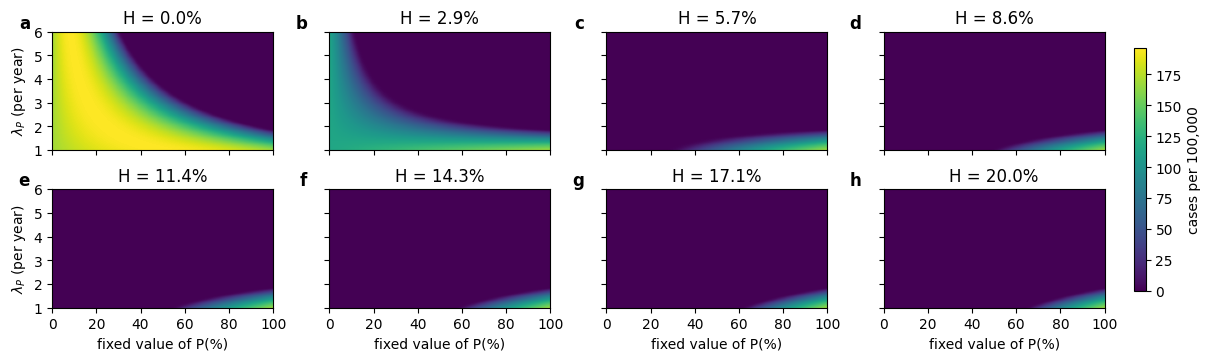

In [6]:
# Load the results from the file
results = np.load("../results/results_discrete_H.npy", allow_pickle=True).item()


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate([results[H]["res_infections"].flatten() for H in Hs])

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

num_H = len(Hs)

# Set up the figure and axes
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_H // 2,
    figsize=(3 * num_H // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, H in enumerate(Hs):
    ax = axes.flat[idx]
    res_infections = results[H]["res_infections"]
    cax = ax.imshow(
        res_infections,
        origin="lower",
        aspect="auto",
        vmin=global_vmin,
        vmax=global_vmax,
        extent=[0, 100, 1 / 360, 6 / 360],
    )
    ax.set_title(f"H = {H * 100:.1f}%")

    # Set xlabels only on the bottom most subplots
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 20, 40, 60, 80, 100])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[40] * 100),
                int(Ps[80] * 100),
                int(Ps[120] * 100),
                int(Ps[160] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if idx % ncols == 0:
        ax.set_ylabel("$\lambda_P$ (per year)")
        ax.set_yticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
        ax.set_yticklabels(["1", "2", "3", "4", "5", "6"])
    else:
        ax.set_yticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.15,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()